# Setup

In [1]:
import os
import numpy as np
np.set_printoptions(suppress=True)
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import roc_curve, roc_auc_score, RocCurveDisplay
import sys

# Load data

In [2]:
comparison_folder = os.path.join(os.path.dirname(os.getcwd()),'data', 'BF_approximation_comparison')
bridge_file = '2021_06_29___15_12_BF_approx_comp'
NN_fixed_file = '2021_07_13___17_52_BF_NN_comp'
NN_variable_file = '2021_07_01___15_24_BF_NN_variable_comp'

bridge = pd.read_csv(os.path.join(comparison_folder, bridge_file), sep = " ").reset_index(drop=True)
NN_fixed = pd.read_csv(os.path.join(comparison_folder, NN_fixed_file))
NN_variable = pd.read_csv(os.path.join(comparison_folder, NN_variable_file))

In [3]:
bridge.head()

,dataset,true_model,m0_prob,m1_prob,selected_model,bayes_factor,m0_bridge_error,m1_bridge_error,compile_time,stan_time,bridge_time
0,1,0,8.388963e-01,0.161104,0,1.920424e-01,0%,0%,39.907145,52.258780,35.962266
1,2,1,2.226466e-27,1.000000,1,4.491424e+26,0%,0%,39.907145,48.838711,35.385838
2,3,1,5.490843e-01,0.450916,0,8.212140e-01,1%,1%,39.907145,125.710194,37.204897
3,4,0,7.737407e-01,0.226259,0,2.924226e-01,0%,0%,39.907145,48.535535,35.359315
4,5,0,5.384046e-01,0.461595,0,8.573394e-01,0%,0%,39.907145,49.718692,35.450406


In [4]:
NN_fixed.head()

,dataset,true_model,m0_prob,m1_prob,selected_model,bayes_factor,training_time,inference_time,final_epoch_loss
0,1,0,0.830657,0.169343,0,0.203867,160.790968,0.055943,0.474433
1,2,1,0.000056,0.999944,1,17961.758030,160.790968,0.055943,0.474433
2,3,1,0.550600,0.449400,0,0.816201,160.790968,0.055943,0.474433
3,4,0,0.856114,0.143886,0,0.168069,160.790968,0.055943,0.474433
4,5,0,0.552386,0.447614,0,0.810329,160.790968,0.055943,0.474433


In [5]:
NN_variable.head()

,dataset,true_model,m0_prob,m1_prob,selected_model,bayes_factor,training_time,inference_time
0,1,0,0.824269,0.175731,0,0.213197,238.349188,0.014821
1,2,1,0.001745,0.998255,1,572.129368,238.349188,0.014821
2,3,1,0.353277,0.646723,1,1.830639,238.349188,0.014821
3,4,0,0.630828,0.369172,0,0.585218,238.349188,0.014821
4,5,0,0.556635,0.443365,0,0.796510,238.349188,0.014821


# Calculate performance metrics

In [6]:
def performance_metrics(bridge_sampling_results, NN_fixed_results, NN_variable_results, names):
    
    mae = []
    rmse = []
    roc_auc = [] 
    accuracy = []
    
    for d in (bridge_sampling_results, NN_fixed_results, NN_variable_results):
        mae_temp = np.mean(abs(d['true_model']-d['m1_prob']))
        mae.append(mae_temp)
        rmse_temp = np.sqrt(((d['true_model']-d['m1_prob'])**2).mean())
        rmse.append(rmse_temp)
        roc_auc_temp = roc_auc_score(d['true_model'], d['m1_prob'])
        roc_auc.append(roc_auc_temp)
        accuracy_temp = (d['true_model'] == d['selected_model']).mean()
        accuracy.append(accuracy_temp)

    
    df = pd.DataFrame([mae, rmse, roc_auc, accuracy], index = ['MAE', 'RMSE', 'ROC AUC', 'Accuracy'], 
                      columns = names).transpose()
    
    return df

In [7]:
perf_metrics = performance_metrics(bridge, NN_fixed, NN_variable, 
                                   names = ['Bridge Sampling', 'Hierarchical Network fixed', 
                                            'Hierarchical Network variable'])
perf_metrics

,MAE,RMSE,ROC AUC,Accuracy
Bridge Sampling,0.228593,0.322116,0.941176,0.86
Hierarchical Network fixed,0.255016,0.349507,0.907163,0.82
Hierarchical Network variable,0.255145,0.333028,0.922769,0.83


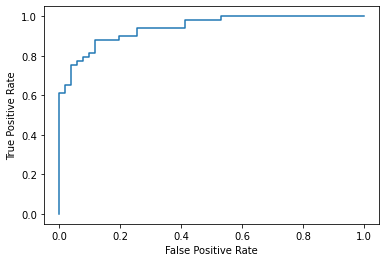

In [8]:
fpr, tpr, thesholds = roc_curve(bridge['true_model'], bridge['m1_prob'])
RocCurveDisplay(fpr=fpr, tpr=tpr).plot() 

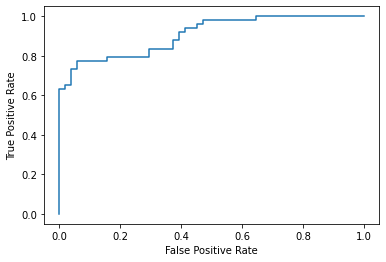

In [9]:
fpr, tpr, thesholds = roc_curve(NN_fixed['true_model'], NN_fixed['m1_prob'])
RocCurveDisplay(fpr=fpr, tpr=tpr).plot() 

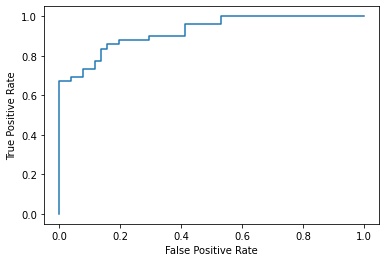

In [10]:
fpr, tpr, thesholds = roc_curve(NN_variable['true_model'], NN_variable['m1_prob'])
RocCurveDisplay(fpr=fpr, tpr=tpr).plot() 

In [11]:
# Inspired by simulation-based calibration: 
# Do the average posterior probabilities match the 50/50 prior 
# / the 49/51 proportion in the simulated datasets?

print('True prior probability for m1 = {}'.format(0.5))
print('True proportion in simulated datasets = {}'.format(bridge['true_model'].mean()))
print('Bridge Sampling average m1 probability = {}'.format(bridge['m1_prob'].mean()))
print('NN fixed average m1 probability = {}'.format(NN_fixed['m1_prob'].mean()))
print('NN variable average m1 probability = {}'.format(NN_variable['m1_prob'].mean()))

True prior probability for m1 = 0.5
True proportion in simulated datasets = 0.49
Bridge Sampling average m1 probability = 0.4974335423669033
NN fixed average m1 probability = 0.4510535007715225
NN variable average m1 probability = 0.5137272714078427


In [12]:
# How do the proportions of selected models look like?

print('True proportion = {}'.format(bridge['true_model'].mean()))
print('Bridge Sampling proportion = {}'.format(bridge['selected_model'].mean()))
print('NN fixed proportion = {}'.format(NN_fixed['selected_model'].mean()))
print('NN variable proportion = {}'.format(NN_variable['selected_model'].mean()))

True proportion = 0.49
Bridge Sampling proportion = 0.39
NN fixed proportion = 0.33
NN variable proportion = 0.46


# Plot log BF approximation

In [13]:
### Variant 1: Replace infinite BFs by highest number possible

def log_with_inf_replacement(x):
    """ Replaces Inf values with highest value possible and 
    then computes the log of the given array. 
    """
    
    x_copy = x.copy()
    if all(np.isfinite(x)) == False:
        x_copy[np.isfinite(x) == False] = sys.maxsize
    x_copy = np.log(x_copy)
    return x_copy

In [14]:
### Variant 2: Add noise to model probs in case of infinite BFs and recompute BFs

def log_with_inf_noise_addition(x):
    """ Replaces Inf values with highest value possible and 
    then computes the log of the given array. 
    """
    
    x_copy = x.copy()
    for i in range(x.shape[0]):
        if x.loc[i,'m0_prob'] == 0:
            x_copy.loc[i,'m0_prob'] = x_copy.loc[i,'m0_prob'] + 0.000000001
            x_copy.loc[i,'m1_prob'] = x_copy.loc[i,'m1_prob'] - 0.000000001
            x_copy.loc[i,'bayes_factor'] = x_copy.loc[i,'m1_prob'] / x_copy.loc[i,'m0_prob']
    x_copy = np.log(x_copy['bayes_factor'])
    return x_copy

In [15]:
# Compute Log BFs

log_bridge_bfs = log_with_inf_noise_addition(bridge)
log_NN_fixed_bfs = log_with_inf_noise_addition(NN_fixed)
log_NN_variable_bfs = log_with_inf_noise_addition(NN_variable)

In [16]:
# how many Bridge Log BFs are > 5?
print((log_bridge_bfs > 5).sum())
# how many NN fixed Log BFs are > 5?
print((log_NN_fixed_bfs > 5).sum())
# how many NN variable Log BFs are > 5?
print((log_NN_variable_bfs > 5).sum())

24
14
10


In [42]:
# Plotting settings

colors = {0:'darkgrey', 1:'black'}
figsize = (5, 5)

Text(0, 0.5, '$p$($M_{2}$|$D$), nicht-amortisiertes Netz')

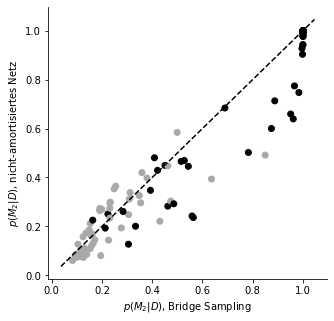

In [43]:
# Posterior probabilities for model 1
# Bridge Sampling vs fixed NN

f, ax = plt.subplots(1, 1, figsize=figsize)
ax.scatter(bridge['m1_prob'], NN_fixed['m1_prob'], c=bridge['true_model'].map(colors))
ax.plot(ax.get_xlim(), ax.get_xlim(), '--', color='black')
ax.spines['right'].set_visible(False)
ax.spines['top'].set_visible(False)
ax.set_xlabel('$p$($M_{2}$|$D$), Bridge Sampling')
ax.set_ylabel('$p$($M_{2}$|$D$), nicht-amortisiertes Netz')
#ax.set_title('Posterior probability approximation: Hierarchical Network trained with fixed dataset sizes')
#f.savefig('figures/BF_toy.png', dpi=300, bbox_inches='tight')

Text(0, 0.5, 'Log $BF_{21}$, nicht-amortisiertes Netz')

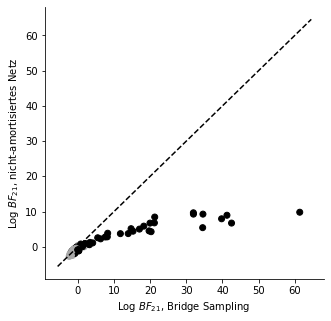

In [44]:
# BFs vs fixed NN

f, ax = plt.subplots(1, 1, figsize=figsize)
ax.scatter(log_bridge_bfs, log_NN_fixed_bfs, c=bridge['true_model'].map(colors))
ax.plot(ax.get_xlim(), ax.get_xlim(), '--', color='black')
ax.spines['right'].set_visible(False)
ax.spines['top'].set_visible(False)
ax.set_xlabel(r'Log $BF_{21}$, Bridge Sampling ')
ax.set_ylabel('Log $BF_{21}$, nicht-amortisiertes Netz')
#ax.set_title('Log Bayes Factor approximation: Hierarchical Network trained with fixed dataset sizes')
#f.savefig('figures/BF_toy.png', dpi=300, bbox_inches='tight')

Text(0, 0.5, '$p$($M_{2}$|$D$), über $L$ & $N$ amortisiertes Netz')

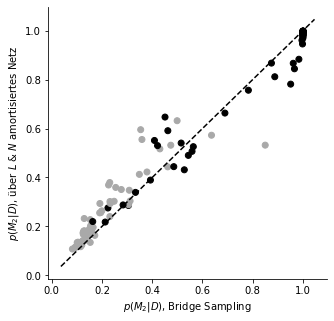

In [45]:
# Posterior probabilities for model 1
# Bridge Sampling vs variable NN

f, ax = plt.subplots(1, 1, figsize=figsize)
ax.scatter(bridge['m1_prob'], NN_variable['m1_prob'], c=bridge['true_model'].map(colors))
ax.plot(ax.get_xlim(), ax.get_xlim(), '--', color='black')
ax.spines['right'].set_visible(False)
ax.spines['top'].set_visible(False)
ax.set_xlabel('$p$($M_{2}$|$D$), Bridge Sampling')
ax.set_ylabel('$p$($M_{2}$|$D$), über $L$ & $N$ amortisiertes Netz')
#ax.set_title('Posterior probability approximation: Hierarchical Network trained with variable dataset sizes')
#f.savefig('figures/BF_toy.png', dpi=300, bbox_inches='tight')

Text(0, 0.5, 'Log $BF_{21}$, über $L$ & $N$ amortisiertes Netz')

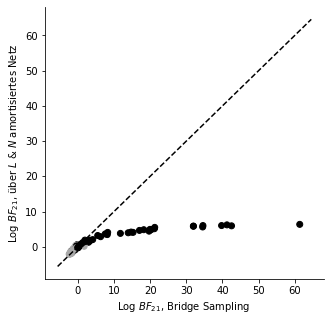

In [46]:
# vs variable NN

f, ax = plt.subplots(1, 1, figsize=figsize)
ax.scatter(log_bridge_bfs, log_NN_variable_bfs, c=bridge['true_model'].map(colors))
ax.plot(ax.get_xlim(), ax.get_xlim(), '--', color='black')
ax.spines['right'].set_visible(False)
ax.spines['top'].set_visible(False)
ax.set_xlabel('Log $BF_{21}$, Bridge Sampling ')
ax.set_ylabel('Log $BF_{21}$, über $L$ & $N$ amortisiertes Netz')
#ax.set_title('Log Bayes Factor approximation: Hierarchical Network trained with variable dataset sizes')
#f.savefig('figures/BF_toy.png', dpi=300, bbox_inches='tight')

# Plot computation time as function of datasets

In [27]:
# Calculate computation times
bridge_time_min = (bridge['compile_time'] + (bridge['stan_time'] + bridge['bridge_time']).cumsum())/60
NN_fixed_time_min = (NN_fixed['training_time'] + NN_fixed['inference_time'].cumsum())/60
NN_variable_time_min = (NN_variable['training_time'] + NN_variable['inference_time'].cumsum())/60

# Set index to represent datasets
bridge_time_min.index = bridge_time_min.index+1
NN_fixed_time_min.index = NN_fixed_time_min.index+1
NN_variable_time_min.index = NN_variable_time_min.index+1

In [28]:
bridge['stan_time']/60

0     0.870980
1     0.813979
2     2.095170
3     0.808926
4     0.828645
        ...   
95    0.996661
96    0.831937
97    0.828789
98    0.822810
99    0.805737
Name: stan_time, Length: 100, dtype: float64

In [29]:
# Mean computation times per phase
# Bridge Sampling
print('Stan: {}'.format(np.mean(bridge['stan_time'])))
print('Bridge: {}'.format(np.mean(bridge['bridge_time'])))

# NN fixed
print('NN fixed training: {}'.format(np.mean(NN_fixed['training_time'])))
print('NN fixed inference: {}'.format(np.mean(NN_fixed['inference_time'])))

# NN variable
print('NN variable training: {}'.format(np.mean(NN_variable['training_time'])))
print('NN variable inference: {}'.format(np.mean(NN_variable['inference_time'])))

Stan: 51.95640207290649
Bridge: 35.198642358779914
NN fixed training: 160.79096840000057
NN fixed inference: 0.055943399998795905
NN variable training: 238.34918789999935
NN variable inference: 0.014820800002780698


(0.0, 153.11292930086452)

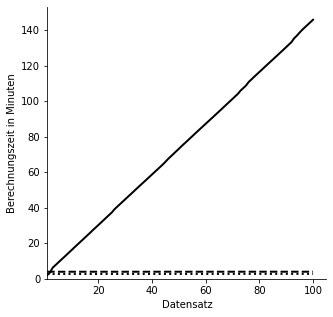

In [30]:
# Plot for all datasets
f, ax = plt.subplots(1, 1, figsize=figsize)
ax.plot(bridge_time_min, label='Bridge Sampling computation time', lw=2, color='black')
ax.plot(NN_fixed_time_min, label='Hierarchical Network fixed computation time', lw=2, linestyle='dotted', color='black')
ax.plot(NN_variable_time_min, label='Hierarchical Network variable computation time', lw=2, linestyle='dashed', color='black')
ax.spines['right'].set_visible(False)
ax.spines['top'].set_visible(False)
ax.set_xlabel('Datensatz')
ax.set_ylabel('Berechnungszeit in Minuten')
ax.set_xlim(xmin=1)
ax.set_ylim(ymin=0)
#ax.legend(loc='upper left')
#f.savefig('figures/BF_N_Toy.png', dpi=300, bbox_inches='tight')

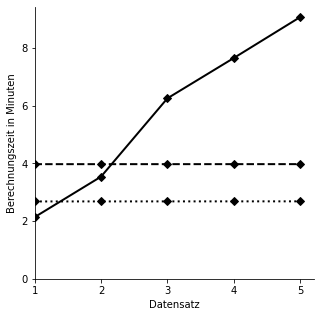

In [31]:
# Plot time for subset of 1-5 datasets

bridge_short = bridge.iloc[:5,:]
NN_fixed_short = NN_fixed.iloc[:5,:]
NN_variable_short = NN_variable.iloc[:5,:]

# Calculate computation times
bridge_time_min = ((bridge_short['compile_time'] + (bridge_short['stan_time'] + bridge_short['bridge_time']).cumsum())/60)
NN_fixed_time_min = ((NN_fixed_short['training_time'] + NN_fixed_short['inference_time'].cumsum())/60)
NN_variable_time_min = ((NN_variable_short['training_time'] + NN_variable_short['inference_time'].cumsum())/60)

# Set index to represent datasets
bridge_time_min.index = bridge_time_min.index+1
NN_fixed_time_min.index = NN_fixed_time_min.index+1
NN_variable_time_min.index = NN_variable_time_min.index+1

# Plot
f, ax = plt.subplots(1, 1, figsize=figsize)
ax.plot(bridge_time_min, label='Bridge Sampling computation time', lw=2, marker='D', color='black')
ax.plot(NN_fixed_time_min, label='Hierarchical Network fixed computation time', lw=2, linestyle='dotted', marker='D', color='black')
ax.plot(NN_variable_time_min, label='Hierarchical Network variable computation time', lw=2, linestyle='dashed', marker='D', color='black')
ax.spines['right'].set_visible(False)
ax.spines['top'].set_visible(False)
ax.set_xlabel('Datensatz')
ax.set_ylabel('Berechnungszeit in Minuten')
ax.set_xlim(xmin=1)
ax.set_ylim(ymin=0)
ax.set_xticks(bridge_time_min.index) # only display ticks for each dataset
#ax.legend(loc='upper left')
#f.savefig('figures/BF_N_Toy.png', dpi=300, bbox_inches='tight')